# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

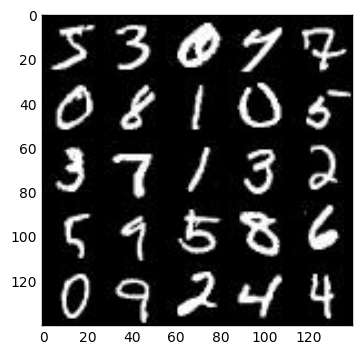

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

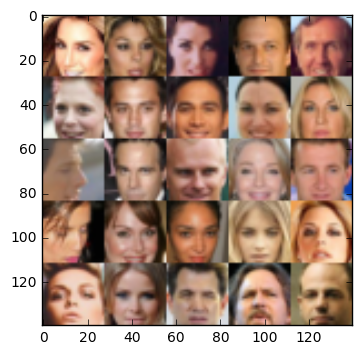

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_fake = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)
    
    return input_real, input_fake, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # Set alpha value
    alpha = 0.2
    
    # Use variable scope 
    with tf.variable_scope('discriminator', reuse= reuse):
        # First layer
        # Convolution
        x1 = tf.layers.conv2d(images, filters = 64, kernel_size = 5, strides = 2, padding = 'same')
        # Activation function: Leaky ReLU
        act1 = tf.maximum(alpha * x1, x1)
        # Image shape = (14*14*64)
        
        # Second layer
        x2 = tf.layers.conv2d(act1, filters = 128, kernel_size = 5, strides = 2, padding = 'same')
        # Batch Norm
        batch_norm2 = tf.layers.batch_normalization(x2, training = True)
        act2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        # Image shape = (7*7*128)
        
        # Third Layer
        x3 = tf.layers.conv2d(act2, filters = 256, kernel_size = 5, strides = 2, padding = 'same')
        batch_norm3 = tf.layers.batch_normalization(x3, training = True)
        act3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        # Image shape = (4*4*256)
        
        # Flatten
        flatten = tf.reshape(act3, (-1, 4 * 4 * 256))
        
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
        
    
    return logits, out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # Set alpha value
    alpha = 0.2
    
    if is_train:
        reuse = False
    else:
        reuse = True
        
    # Use variable scope 
    with tf.variable_scope('generator', reuse = reuse):
        # First layer
        # Project
        x1 = tf.layers.dense(z, 7 * 7 * 1024)
        # Reshape
        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        # Batch norm
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        # Activation function = Leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        # x1 shape = (7x7x1024)

        # Second layer
        x2 = tf.layers.conv2d_transpose(x1, filters = 512, kernel_size = 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # x2 shape = (14*14*512)

        # Third layer
        logits = tf.layers.conv2d_transpose(x2, filters = out_channel_dim, kernel_size = 5, strides = 2, padding = 'same')
        # logits shape = (28x28xout_channel_dim)

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_logits_real, d_model_real = discriminator(input_real)
    d_logits_fake, d_model_fake = discriminator(g_model, reuse = True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    
    d_loss_real = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get trainable variables
    t_vars = tf.trainable_variables()
    # Discriminator variables
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    # Generator variables
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_update_ops = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_update_ops = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Get height, width, channels of image
    _, img_height, img_width, img_channels = data_shape
    
    # Get input real, fake and learning rate
    input_real, input_fake, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    # Get loss of discriminator and generator
    d_loss, g_loss = model_loss(input_real, input_fake, img_channels)
    # Optimization
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    show_every = 100
    print_every = 10
    steps = 0
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # -0.5 ~ 0.5 -> -1 ~ 1
                batch_images *= 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_fake: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_fake: batch_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # Print progress at every print_every
                    train_loss_d = d_loss.eval(feed_dict = {input_real: batch_images, input_fake: batch_z})
                    train_loss_g = g_loss.eval(feed_dict = {input_fake: batch_z})
                    
                    print("Epoch: " + str(epoch_i) + ' / ' + 
                          "Discriminator loss: " + str(train_loss_d) + ' / ' + 
                          "Generator loss: " + str(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                # Show progress at every show_every
                n_images = 50
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_fake, img_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 / Discriminator loss: 0.045384 / Generator loss: 6.0385
Epoch: 0 / Discriminator loss: 0.128339 / Generator loss: 2.38206
Epoch: 0 / Discriminator loss: 0.311278 / Generator loss: 1.51708
Epoch: 0 / Discriminator loss: 0.0252858 / Generator loss: 4.68185
Epoch: 0 / Discriminator loss: 2.00371 / Generator loss: 10.6599
Epoch: 0 / Discriminator loss: 0.734898 / Generator loss: 3.06619
Epoch: 0 / Discriminator loss: 1.36374 / Generator loss: 0.439859
Epoch: 0 / Discriminator loss: 1.0173 / Generator loss: 1.95024
Epoch: 0 / Discriminator loss: 0.85435 / Generator loss: 1.57344
Epoch: 0 / Discriminator loss: 1.13471 / Generator loss: 1.40639


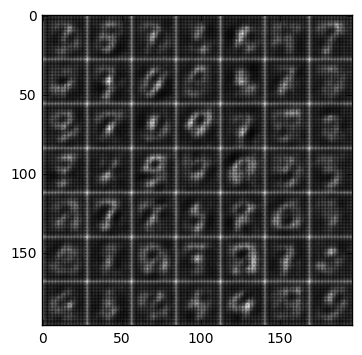

Epoch: 0 / Discriminator loss: 1.18371 / Generator loss: 1.36187
Epoch: 0 / Discriminator loss: 1.12435 / Generator loss: 1.31656
Epoch: 0 / Discriminator loss: 1.25717 / Generator loss: 0.645459
Epoch: 0 / Discriminator loss: 1.60969 / Generator loss: 0.32023
Epoch: 0 / Discriminator loss: 1.13428 / Generator loss: 0.935264
Epoch: 0 / Discriminator loss: 1.29488 / Generator loss: 0.516641
Epoch: 0 / Discriminator loss: 1.14065 / Generator loss: 0.73076
Epoch: 0 / Discriminator loss: 1.0326 / Generator loss: 1.48101
Epoch: 0 / Discriminator loss: 0.931899 / Generator loss: 0.84706
Epoch: 0 / Discriminator loss: 0.988293 / Generator loss: 0.943182


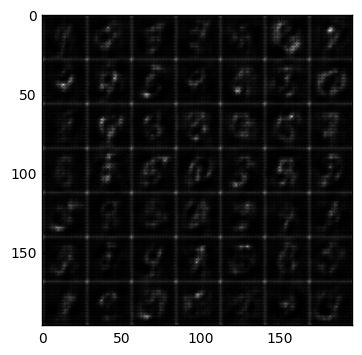

Epoch: 0 / Discriminator loss: 1.06686 / Generator loss: 1.40751
Epoch: 0 / Discriminator loss: 0.920689 / Generator loss: 1.01302
Epoch: 0 / Discriminator loss: 1.16737 / Generator loss: 0.556207
Epoch: 0 / Discriminator loss: 0.838815 / Generator loss: 1.15063
Epoch: 0 / Discriminator loss: 1.07897 / Generator loss: 2.02545
Epoch: 0 / Discriminator loss: 0.881944 / Generator loss: 1.45416
Epoch: 0 / Discriminator loss: 0.784339 / Generator loss: 1.69154
Epoch: 0 / Discriminator loss: 1.18923 / Generator loss: 0.549424
Epoch: 0 / Discriminator loss: 0.733764 / Generator loss: 1.63693
Epoch: 0 / Discriminator loss: 0.787533 / Generator loss: 0.914201


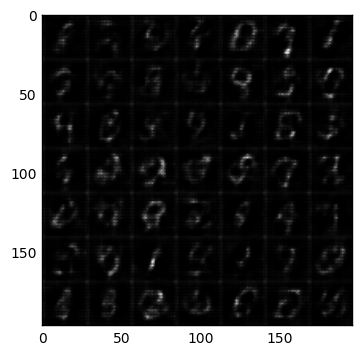

Epoch: 0 / Discriminator loss: 0.911324 / Generator loss: 0.750123
Epoch: 0 / Discriminator loss: 0.65502 / Generator loss: 1.4674
Epoch: 0 / Discriminator loss: 0.952207 / Generator loss: 0.754452
Epoch: 0 / Discriminator loss: 0.926577 / Generator loss: 1.10013
Epoch: 0 / Discriminator loss: 0.767732 / Generator loss: 1.12416
Epoch: 0 / Discriminator loss: 1.07345 / Generator loss: 0.757326
Epoch: 0 / Discriminator loss: 0.929225 / Generator loss: 1.76721
Epoch: 0 / Discriminator loss: 0.980621 / Generator loss: 1.07494
Epoch: 0 / Discriminator loss: 1.44163 / Generator loss: 0.391994
Epoch: 0 / Discriminator loss: 0.948735 / Generator loss: 0.817531


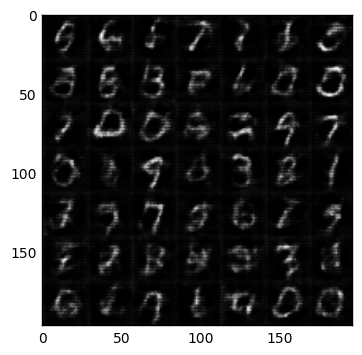

Epoch: 0 / Discriminator loss: 1.12156 / Generator loss: 1.73017
Epoch: 0 / Discriminator loss: 0.841853 / Generator loss: 1.18049
Epoch: 0 / Discriminator loss: 0.988299 / Generator loss: 1.0807
Epoch: 0 / Discriminator loss: 0.961666 / Generator loss: 0.779068
Epoch: 0 / Discriminator loss: 0.914306 / Generator loss: 1.09461
Epoch: 0 / Discriminator loss: 0.948504 / Generator loss: 1.34873
Epoch: 1 / Discriminator loss: 1.13025 / Generator loss: 1.32022
Epoch: 1 / Discriminator loss: 0.903379 / Generator loss: 0.862893
Epoch: 1 / Discriminator loss: 1.04818 / Generator loss: 1.39011
Epoch: 1 / Discriminator loss: 1.10468 / Generator loss: 0.71348


Epoch: 1 / Discriminator loss: 0.892277 / Generator loss: 0.865995
Epoch: 1 / Discriminator loss: 1.14544 / Generator loss: 0.547699
Epoch: 1 / Discriminator loss: 1.26777 / Generator loss: 0.452434
Epoch: 1 / Discriminator loss: 1.09502 / Generator loss: 0.584636
Epoch: 1 / Discriminator loss: 1.03535 / Generator loss: 1.34196
Epoch: 1 / Discriminator loss: 0.798017 / Generator loss: 1.44831
Epoch: 1 / Discriminator loss: 0.932425 / Generator loss: 0.99641
Epoch: 1 / Discriminator loss: 0.934616 / Generator loss: 1.34503
Epoch: 1 / Discriminator loss: 0.976249 / Generator loss: 0.88083
Epoch: 1 / Discriminator loss: 0.996802 / Generator loss: 0.781065


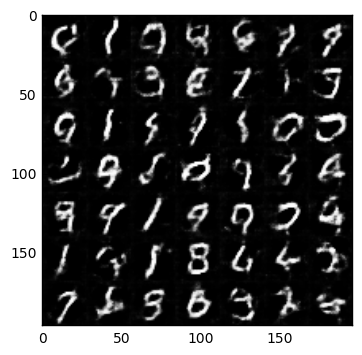

Epoch: 1 / Discriminator loss: 1.20955 / Generator loss: 0.496259
Epoch: 1 / Discriminator loss: 0.881493 / Generator loss: 1.20557
Epoch: 1 / Discriminator loss: 0.891621 / Generator loss: 1.22935
Epoch: 1 / Discriminator loss: 0.872524 / Generator loss: 1.15035
Epoch: 1 / Discriminator loss: 0.916896 / Generator loss: 0.860431
Epoch: 1 / Discriminator loss: 1.04748 / Generator loss: 0.734766
Epoch: 1 / Discriminator loss: 0.914148 / Generator loss: 1.01835
Epoch: 1 / Discriminator loss: 0.965174 / Generator loss: 1.46676
Epoch: 1 / Discriminator loss: 0.831017 / Generator loss: 1.53486
Epoch: 1 / Discriminator loss: 0.979934 / Generator loss: 1.02438


Epoch: 1 / Discriminator loss: 0.995006 / Generator loss: 0.728745
Epoch: 1 / Discriminator loss: 0.7985 / Generator loss: 1.05543
Epoch: 1 / Discriminator loss: 0.970984 / Generator loss: 0.812019
Epoch: 1 / Discriminator loss: 0.82034 / Generator loss: 1.12438
Epoch: 1 / Discriminator loss: 1.01409 / Generator loss: 0.768951
Epoch: 1 / Discriminator loss: 0.852556 / Generator loss: 1.88169
Epoch: 1 / Discriminator loss: 0.806027 / Generator loss: 1.00825
Epoch: 1 / Discriminator loss: 0.886589 / Generator loss: 1.07069
Epoch: 1 / Discriminator loss: 0.958564 / Generator loss: 0.683413
Epoch: 1 / Discriminator loss: 0.833403 / Generator loss: 1.14268


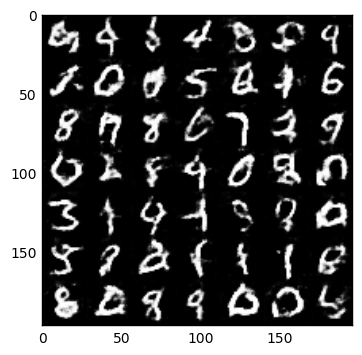

Epoch: 1 / Discriminator loss: 0.806897 / Generator loss: 0.831881
Epoch: 1 / Discriminator loss: 0.87689 / Generator loss: 1.7429
Epoch: 1 / Discriminator loss: 0.71784 / Generator loss: 1.18423
Epoch: 1 / Discriminator loss: 0.81951 / Generator loss: 0.881045
Epoch: 1 / Discriminator loss: 0.806281 / Generator loss: 1.03738
Epoch: 1 / Discriminator loss: 1.32828 / Generator loss: 0.439833
Epoch: 1 / Discriminator loss: 0.902162 / Generator loss: 0.783156
Epoch: 1 / Discriminator loss: 0.707598 / Generator loss: 1.18517
Epoch: 1 / Discriminator loss: 0.73852 / Generator loss: 1.00584
Epoch: 1 / Discriminator loss: 1.41124 / Generator loss: 2.96702


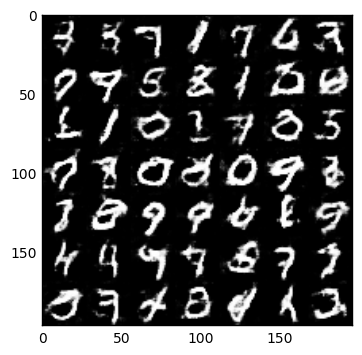

Epoch: 1 / Discriminator loss: 1.06884 / Generator loss: 0.734097
Epoch: 1 / Discriminator loss: 0.800267 / Generator loss: 0.92994
Epoch: 1 / Discriminator loss: 0.807397 / Generator loss: 1.09019


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 / Discriminator loss: 3.32011 / Generator loss: 0.100446
Epoch: 0 / Discriminator loss: 1.98368 / Generator loss: 0.374247
Epoch: 0 / Discriminator loss: 1.92307 / Generator loss: 0.459245
Epoch: 0 / Discriminator loss: 1.51921 / Generator loss: 0.64492
Epoch: 0 / Discriminator loss: 1.47526 / Generator loss: 0.785512
Epoch: 0 / Discriminator loss: 1.62551 / Generator loss: 0.608242
Epoch: 0 / Discriminator loss: 1.62625 / Generator loss: 0.639373
Epoch: 0 / Discriminator loss: 1.56383 / Generator loss: 0.570566
Epoch: 0 / Discriminator loss: 1.64113 / Generator loss: 0.625284
Epoch: 0 / Discriminator loss: 1.7031 / Generator loss: 0.558416


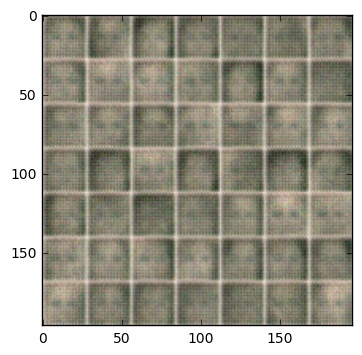

Epoch: 0 / Discriminator loss: 1.56276 / Generator loss: 0.652912
Epoch: 0 / Discriminator loss: 1.54202 / Generator loss: 0.574985
Epoch: 0 / Discriminator loss: 1.55886 / Generator loss: 0.581507
Epoch: 0 / Discriminator loss: 1.49124 / Generator loss: 0.691091
Epoch: 0 / Discriminator loss: 1.49304 / Generator loss: 0.655982
Epoch: 0 / Discriminator loss: 1.39295 / Generator loss: 0.633384
Epoch: 0 / Discriminator loss: 1.28235 / Generator loss: 0.885085
Epoch: 0 / Discriminator loss: 1.49955 / Generator loss: 0.514225
Epoch: 0 / Discriminator loss: 1.4999 / Generator loss: 0.625726
Epoch: 0 / Discriminator loss: 1.52724 / Generator loss: 0.527772


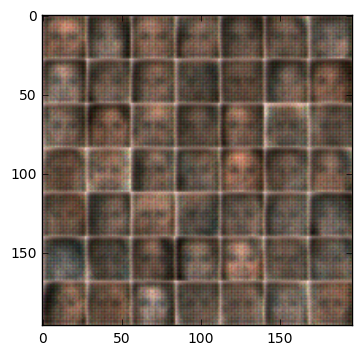

Epoch: 0 / Discriminator loss: 1.53842 / Generator loss: 0.59966
Epoch: 0 / Discriminator loss: 1.51714 / Generator loss: 0.609322
Epoch: 0 / Discriminator loss: 1.46614 / Generator loss: 0.673751
Epoch: 0 / Discriminator loss: 1.36567 / Generator loss: 0.789413
Epoch: 0 / Discriminator loss: 1.39401 / Generator loss: 0.738662
Epoch: 0 / Discriminator loss: 1.47 / Generator loss: 0.520833
Epoch: 0 / Discriminator loss: 1.51085 / Generator loss: 0.447444
Epoch: 0 / Discriminator loss: 1.21897 / Generator loss: 1.37982
Epoch: 0 / Discriminator loss: 1.34886 / Generator loss: 0.539255
Epoch: 0 / Discriminator loss: 1.10383 / Generator loss: 1.30667


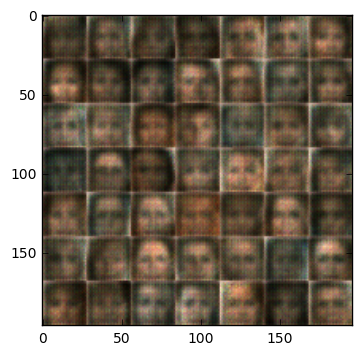

Epoch: 0 / Discriminator loss: 1.16594 / Generator loss: 0.837026
Epoch: 0 / Discriminator loss: 1.12336 / Generator loss: 1.65745
Epoch: 0 / Discriminator loss: 1.0804 / Generator loss: 1.78726
Epoch: 0 / Discriminator loss: 1.17744 / Generator loss: 0.534712
Epoch: 0 / Discriminator loss: 1.35457 / Generator loss: 0.479688
Epoch: 0 / Discriminator loss: 0.850113 / Generator loss: 1.12401
Epoch: 0 / Discriminator loss: 0.634585 / Generator loss: 2.23099
Epoch: 0 / Discriminator loss: 1.21091 / Generator loss: 0.482396
Epoch: 0 / Discriminator loss: 1.16899 / Generator loss: 0.569671
Epoch: 0 / Discriminator loss: 1.09681 / Generator loss: 0.73001


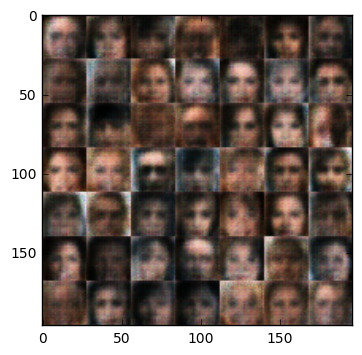

Epoch: 0 / Discriminator loss: 0.602507 / Generator loss: 2.41938
Epoch: 0 / Discriminator loss: 0.892877 / Generator loss: 1.15283
Epoch: 0 / Discriminator loss: 0.698703 / Generator loss: 1.67194
Epoch: 0 / Discriminator loss: 1.32885 / Generator loss: 0.660144
Epoch: 0 / Discriminator loss: 1.33468 / Generator loss: 0.469323
Epoch: 0 / Discriminator loss: 1.10655 / Generator loss: 0.715846
Epoch: 0 / Discriminator loss: 1.29854 / Generator loss: 1.99726
Epoch: 0 / Discriminator loss: 1.03301 / Generator loss: 1.02483
Epoch: 0 / Discriminator loss: 0.645498 / Generator loss: 1.5319
Epoch: 0 / Discriminator loss: 0.884688 / Generator loss: 0.811961


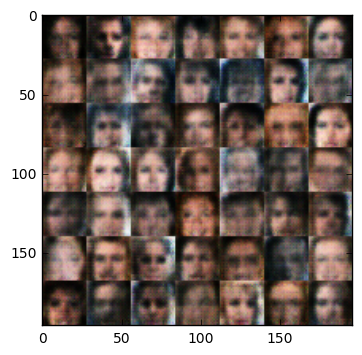

Epoch: 0 / Discriminator loss: 0.670372 / Generator loss: 1.94559
Epoch: 0 / Discriminator loss: 0.635971 / Generator loss: 1.70194
Epoch: 0 / Discriminator loss: 1.41051 / Generator loss: 0.409306
Epoch: 0 / Discriminator loss: 1.47701 / Generator loss: 1.53692
Epoch: 0 / Discriminator loss: 0.52132 / Generator loss: 1.86645
Epoch: 0 / Discriminator loss: 2.09541 / Generator loss: 0.175496
Epoch: 0 / Discriminator loss: 1.78399 / Generator loss: 0.373246
Epoch: 0 / Discriminator loss: 1.25567 / Generator loss: 1.51678
Epoch: 0 / Discriminator loss: 1.26687 / Generator loss: 1.06511
Epoch: 0 / Discriminator loss: 0.900428 / Generator loss: 1.9705


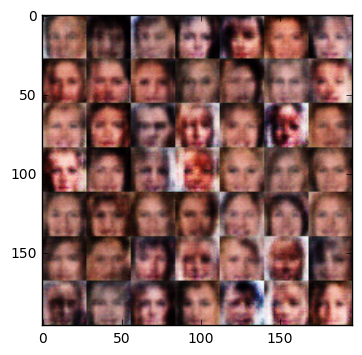

Epoch: 0 / Discriminator loss: 1.14644 / Generator loss: 1.598
Epoch: 0 / Discriminator loss: 1.52232 / Generator loss: 1.29891
Epoch: 0 / Discriminator loss: 1.46306 / Generator loss: 0.626296
Epoch: 0 / Discriminator loss: 1.35216 / Generator loss: 0.813787
Epoch: 0 / Discriminator loss: 1.03474 / Generator loss: 1.29921
Epoch: 0 / Discriminator loss: 1.36739 / Generator loss: 0.644937
Epoch: 0 / Discriminator loss: 1.54311 / Generator loss: 0.450488
Epoch: 0 / Discriminator loss: 1.54508 / Generator loss: 0.698725
Epoch: 0 / Discriminator loss: 1.53101 / Generator loss: 0.554116
Epoch: 0 / Discriminator loss: 1.16695 / Generator loss: 1.04606


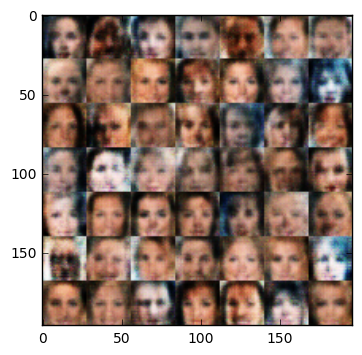

Epoch: 0 / Discriminator loss: 1.20439 / Generator loss: 0.767209
Epoch: 0 / Discriminator loss: 1.45251 / Generator loss: 0.651976
Epoch: 0 / Discriminator loss: 1.42583 / Generator loss: 0.660801
Epoch: 0 / Discriminator loss: 1.50876 / Generator loss: 0.594446
Epoch: 0 / Discriminator loss: 1.45518 / Generator loss: 0.658517
Epoch: 0 / Discriminator loss: 1.30853 / Generator loss: 0.731034
Epoch: 0 / Discriminator loss: 1.31536 / Generator loss: 0.749972
Epoch: 0 / Discriminator loss: 1.33366 / Generator loss: 0.773842
Epoch: 0 / Discriminator loss: 1.40201 / Generator loss: 0.664263
Epoch: 0 / Discriminator loss: 1.49898 / Generator loss: 0.655659


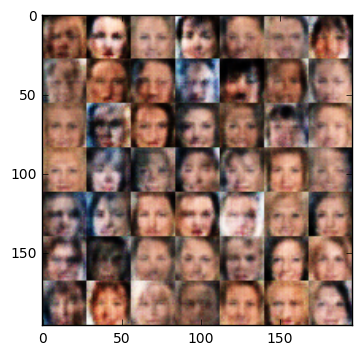

Epoch: 0 / Discriminator loss: 1.39122 / Generator loss: 0.686013
Epoch: 0 / Discriminator loss: 1.52231 / Generator loss: 0.661199
Epoch: 0 / Discriminator loss: 1.37709 / Generator loss: 0.701579
Epoch: 0 / Discriminator loss: 1.52447 / Generator loss: 0.648063
Epoch: 0 / Discriminator loss: 1.38606 / Generator loss: 0.678862
Epoch: 0 / Discriminator loss: 1.47289 / Generator loss: 0.69985
Epoch: 0 / Discriminator loss: 1.41723 / Generator loss: 0.661658
Epoch: 0 / Discriminator loss: 1.377 / Generator loss: 0.683249
Epoch: 0 / Discriminator loss: 1.41502 / Generator loss: 0.703085
Epoch: 0 / Discriminator loss: 1.52956 / Generator loss: 0.625612


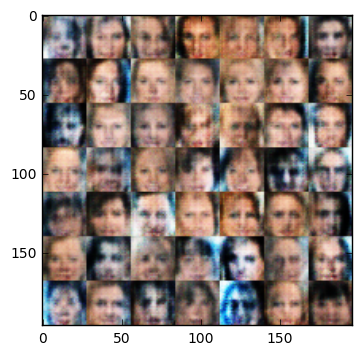

Epoch: 0 / Discriminator loss: 1.40216 / Generator loss: 0.722885
Epoch: 0 / Discriminator loss: 1.47012 / Generator loss: 0.693108
Epoch: 0 / Discriminator loss: 1.39639 / Generator loss: 0.675936
Epoch: 0 / Discriminator loss: 1.4439 / Generator loss: 0.651727
Epoch: 0 / Discriminator loss: 1.39497 / Generator loss: 0.718604
Epoch: 0 / Discriminator loss: 1.38906 / Generator loss: 0.678407
Epoch: 0 / Discriminator loss: 1.38186 / Generator loss: 0.71144
Epoch: 0 / Discriminator loss: 1.42712 / Generator loss: 0.639667
Epoch: 0 / Discriminator loss: 1.36123 / Generator loss: 0.714754
Epoch: 0 / Discriminator loss: 1.40155 / Generator loss: 0.658251


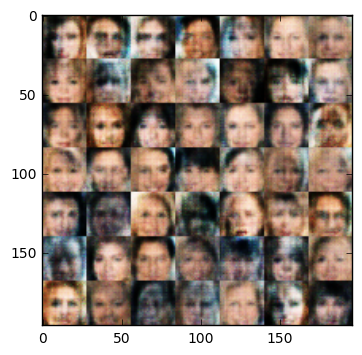

Epoch: 0 / Discriminator loss: 1.29629 / Generator loss: 0.744253
Epoch: 0 / Discriminator loss: 1.46088 / Generator loss: 0.6373
Epoch: 0 / Discriminator loss: 1.42122 / Generator loss: 0.702034
Epoch: 0 / Discriminator loss: 1.441 / Generator loss: 0.703727
Epoch: 0 / Discriminator loss: 1.37593 / Generator loss: 0.684403
Epoch: 0 / Discriminator loss: 1.36243 / Generator loss: 0.719208
Epoch: 0 / Discriminator loss: 1.37499 / Generator loss: 0.703738
Epoch: 0 / Discriminator loss: 1.33222 / Generator loss: 0.718882
Epoch: 0 / Discriminator loss: 1.48588 / Generator loss: 0.588313
Epoch: 0 / Discriminator loss: 1.3866 / Generator loss: 0.717379


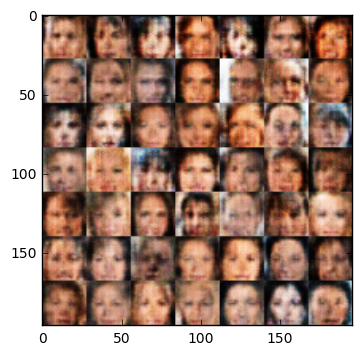

Epoch: 0 / Discriminator loss: 1.35239 / Generator loss: 0.741677
Epoch: 0 / Discriminator loss: 1.43902 / Generator loss: 0.702065
Epoch: 0 / Discriminator loss: 1.34324 / Generator loss: 0.724155
Epoch: 0 / Discriminator loss: 1.54417 / Generator loss: 0.642534
Epoch: 0 / Discriminator loss: 1.26946 / Generator loss: 0.727124
Epoch: 0 / Discriminator loss: 1.52504 / Generator loss: 0.651977
Epoch: 0 / Discriminator loss: 1.35756 / Generator loss: 0.725487
Epoch: 0 / Discriminator loss: 1.51984 / Generator loss: 0.62041
Epoch: 0 / Discriminator loss: 1.33094 / Generator loss: 0.74215
Epoch: 0 / Discriminator loss: 1.26934 / Generator loss: 0.786858


Epoch: 0 / Discriminator loss: 1.36986 / Generator loss: 0.71166
Epoch: 0 / Discriminator loss: 1.34846 / Generator loss: 0.764773
Epoch: 0 / Discriminator loss: 1.38001 / Generator loss: 0.718022
Epoch: 0 / Discriminator loss: 1.3708 / Generator loss: 0.724701
Epoch: 0 / Discriminator loss: 1.45873 / Generator loss: 0.718697
Epoch: 0 / Discriminator loss: 1.32145 / Generator loss: 0.746214
Epoch: 0 / Discriminator loss: 1.33557 / Generator loss: 0.722778
Epoch: 0 / Discriminator loss: 1.41805 / Generator loss: 0.697343
Epoch: 0 / Discriminator loss: 1.37672 / Generator loss: 0.768765
Epoch: 0 / Discriminator loss: 1.43054 / Generator loss: 0.664305


Epoch: 0 / Discriminator loss: 1.46665 / Generator loss: 0.641049
Epoch: 0 / Discriminator loss: 1.42657 / Generator loss: 0.6532
Epoch: 0 / Discriminator loss: 1.36892 / Generator loss: 0.698913
Epoch: 0 / Discriminator loss: 1.3822 / Generator loss: 0.674738
Epoch: 0 / Discriminator loss: 1.34885 / Generator loss: 0.713537
Epoch: 0 / Discriminator loss: 1.39781 / Generator loss: 0.742228
Epoch: 0 / Discriminator loss: 1.3494 / Generator loss: 0.75758
Epoch: 0 / Discriminator loss: 1.40691 / Generator loss: 0.686371
Epoch: 0 / Discriminator loss: 1.34417 / Generator loss: 0.779618
Epoch: 0 / Discriminator loss: 1.40188 / Generator loss: 0.692226


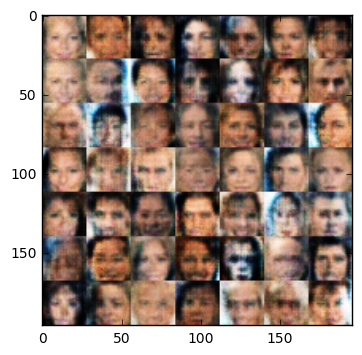

Epoch: 0 / Discriminator loss: 1.37597 / Generator loss: 0.701465
Epoch: 0 / Discriminator loss: 1.37416 / Generator loss: 0.674239
Epoch: 0 / Discriminator loss: 1.37577 / Generator loss: 0.705834
Epoch: 0 / Discriminator loss: 1.41505 / Generator loss: 0.758321
Epoch: 0 / Discriminator loss: 1.34059 / Generator loss: 0.730409
Epoch: 0 / Discriminator loss: 1.43611 / Generator loss: 0.675416
Epoch: 0 / Discriminator loss: 1.4019 / Generator loss: 0.679696
Epoch: 0 / Discriminator loss: 1.3542 / Generator loss: 0.715985
Epoch: 0 / Discriminator loss: 1.42483 / Generator loss: 0.695756
Epoch: 0 / Discriminator loss: 1.31489 / Generator loss: 0.697836


Epoch: 0 / Discriminator loss: 1.40084 / Generator loss: 0.687232
Epoch: 0 / Discriminator loss: 1.42514 / Generator loss: 0.672419
Epoch: 0 / Discriminator loss: 1.37938 / Generator loss: 0.743833
Epoch: 0 / Discriminator loss: 1.52418 / Generator loss: 0.623313
Epoch: 0 / Discriminator loss: 1.3081 / Generator loss: 0.762061
Epoch: 0 / Discriminator loss: 1.3989 / Generator loss: 0.687522
Epoch: 0 / Discriminator loss: 1.33254 / Generator loss: 0.709697
Epoch: 0 / Discriminator loss: 1.42594 / Generator loss: 0.674442


In [25]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.